# Gibbs Sampling: Theory and Implementation from Scratch

## Introduction

Gibbs sampling is a powerful Markov Chain Monte Carlo (MCMC) method particularly well-suited for sampling from multivariate distributions when the conditional distributions of each variable (given all others) are known and easy to sample from. Named after physicist Josiah Willard Gibbs, this algorithm is widely used in Bayesian statistics, machine learning, and statistical physics.

In this notebook, we will:
1. Explore the theoretical foundations of the Gibbs sampling algorithm
2. Implement the algorithm from scratch in Python
3. Apply it to sample from a bivariate normal distribution
4. Extend it to a more complex problem: Bayesian mixture model
5. Analyze the algorithm's performance and limitations

Let's begin by importing the necessary libraries.

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from scipy import stats
import pandas as pd
from tqdm.notebook import tqdm

# Set random seed for reproducibility
np.random.seed(42)

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('notebook')

## 1. Theoretical Background

### 1.1 The Gibbs Sampling Algorithm

Gibbs sampling is a special case of the Metropolis-Hastings algorithm where proposals are always accepted. It works by sampling each variable conditionally on all others. For a target joint distribution $p(x_1, x_2, \ldots, x_n)$, the algorithm works as follows:

1. Start with initial values for all variables $(x_1^{(0)}, x_2^{(0)}, \ldots, x_n^{(0)})$
2. For each iteration $t = 0, 1, 2, \ldots$:
   - a. Sample $x_1^{(t+1)} \sim p(x_1 | x_2^{(t)}, x_3^{(t)}, \ldots, x_n^{(t)})$
   - b. Sample $x_2^{(t+1)} \sim p(x_2 | x_1^{(t+1)}, x_3^{(t)}, \ldots, x_n^{(t)})$
   - c. $\ldots$
   - d. Sample $x_n^{(t+1)} \sim p(x_n | x_1^{(t+1)}, x_2^{(t+1)}, \ldots, x_{n-1}^{(t+1)})$

The key insight is that we only need to know the conditional distributions $p(x_i | x_1, \ldots, x_{i-1}, x_{i+1}, \ldots, x_n)$ for each variable $x_i$, not the full joint distribution.

### 1.2 Key Properties

- **Always Accepts Proposals**: Unlike the Metropolis algorithm, Gibbs sampling always accepts the proposed moves, resulting in an acceptance rate of 100%.

- **Requires Conditional Distributions**: The algorithm requires that we can sample from the conditional distribution of each variable given all others.

- **Detailed Balance**: Gibbs sampling satisfies detailed balance, which guarantees that the stationary distribution of the Markov chain is the target distribution.

- **Coordinate-wise Updates**: The algorithm updates one variable at a time, which can be inefficient when variables are highly correlated.

### 1.3 Practical Considerations

- **Burn-in Period**: Initial samples are discarded to allow the chain to reach its stationary distribution.

- **Thinning**: To reduce autocorrelation, we might keep only every $k$-th sample.

- **Multiple Chains**: Running multiple chains from different starting points helps assess convergence.

- **Sampling Order**: The order in which variables are updated can affect efficiency. Options include:
  - Systematic scan: Update variables in a fixed order
  - Random scan: Randomly select variables to update
  - Blocked Gibbs: Update groups of variables together

Now, let's implement the Gibbs sampling algorithm from scratch.

## 2. Implementation from Scratch

We'll start by implementing a general Gibbs sampler that can work with any set of conditional sampling functions.

In [2]:
def gibbs_sampler(conditional_samplers, initial_state, n_samples, burn_in=0, thin=1):
    """
    Gibbs sampling algorithm for sampling from a multivariate distribution.
    
    Parameters:
    -----------
    conditional_samplers : list of functions
        List of functions that sample from conditional distributions.
        Each function takes the current state and returns a new value for its variable.
    initial_state : array-like
        Initial state of the Markov chain
    n_samples : int
        Number of samples to generate
    burn_in : int, optional
        Number of initial samples to discard
    thin : int, optional
        Thinning factor (keep every thin-th sample)
        
    Returns:
    --------
    samples : array
        Generated samples
    """
    # Convert initial state to numpy array if it isn't already
    current_state = np.array(initial_state, dtype=float)
    dim = current_state.shape[0]  # Dimensionality of the state
    
    # Total number of iterations needed
    n_iterations = burn_in + thin * n_samples
    
    # Initialize storage for samples
    samples = np.zeros((n_samples, dim))
    
    # Main sampling loop
    sample_idx = 0
    for i in tqdm(range(n_iterations), desc="Sampling"):
        # Update each variable using its conditional sampler
        for j, sampler in enumerate(conditional_samplers):
            current_state[j] = sampler(current_state)
        
        # Store the sample if past burn-in and due for storage based on thinning
        if i >= burn_in and (i - burn_in) % thin == 0:
            samples[sample_idx] = current_state
            sample_idx += 1
    
    return samples

## 3. Example 1: Sampling from a Bivariate Normal Distribution

Let's apply our Gibbs sampler to a bivariate normal distribution. This is a good test case because:
1. The conditional distributions are known analytically (they are univariate normals)
2. We can visualize the results in 2D
3. It demonstrates how Gibbs sampling moves parallel to the axes
4. It shows how correlation affects mixing and efficiency

For a bivariate normal distribution with mean $\mu = [\mu_1, \mu_2]$ and covariance matrix $\Sigma = \begin{bmatrix} \sigma_1^2 & \rho\sigma_1\sigma_2 \\ \rho\sigma_1\sigma_2 & \sigma_2^2 \end{bmatrix}$, the conditional distributions are:

$$p(x_1 | x_2) = \mathcal{N}\left(\mu_1 + \rho\frac{\sigma_1}{\sigma_2}(x_2 - \mu_2), \sigma_1^2(1-\rho^2)\right)$$

$$p(x_2 | x_1) = \mathcal{N}\left(\mu_2 + \rho\frac{\sigma_2}{\sigma_1}(x_1 - \mu_1), \sigma_2^2(1-\rho^2)\right)$$

Let's implement these conditional samplers.

In [3]:
def create_bivariate_normal_conditional_samplers(mean, cov):
    """
    Create conditional samplers for a bivariate normal distribution.
    
    Parameters:
    -----------
    mean : array-like
        Mean vector [mu_1, mu_2]
    cov : array-like
        Covariance matrix [[sigma_1^2, rho*sigma_1*sigma_2], [rho*sigma_1*sigma_2, sigma_2^2]]
        
    Returns:
    --------
    samplers : list of functions
        Conditional samplers for x_1|x_2 and x_2|x_1
    """
    mu_1, mu_2 = mean
    sigma_1_sq, rho_sigma_1_sigma_2, _, sigma_2_sq = cov.flatten()
    
    sigma_1 = np.sqrt(sigma_1_sq)
    sigma_2 = np.sqrt(sigma_2_sq)
    rho = rho_sigma_1_sigma_2 / (sigma_1 * sigma_2)
    
    # Conditional standard deviations
    cond_std_1 = sigma_1 * np.sqrt(1 - rho**2)
    cond_std_2 = sigma_2 * np.sqrt(1 - rho**2)
    
    # Conditional sampler for x_1|x_2
    def sample_x1_given_x2(state):
        x2 = state[1]
        cond_mean_1 = mu_1 + rho * (sigma_1 / sigma_2) * (x2 - mu_2)
        return np.random.normal(cond_mean_1, cond_std_1)
    
    # Conditional sampler for x_2|x_1
    def sample_x2_given_x1(state):
        x1 = state[0]
        cond_mean_2 = mu_2 + rho * (sigma_2 / sigma_1) * (x1 - mu_1)
        return np.random.normal(cond_mean_2, cond_std_2)
    
    return [sample_x1_given_x2, sample_x2_given_x1]

Now, let's run the Gibbs sampler for a bivariate normal distribution with correlation.

In [4]:
# Define parameters for the target distribution
mean = np.array([0, 0])
rho = 0.8  # Correlation coefficient
cov = np.array([[1, rho], [rho, 1]])

# Create conditional samplers
conditional_samplers = create_bivariate_normal_conditional_samplers(mean, cov)

# Set sampling parameters
initial_state = np.array([2, 2])  # Start away from the mean
n_samples = 5000
burn_in = 1000
thin = 1

# Run the Gibbs sampler
samples = gibbs_sampler(conditional_samplers, initial_state, n_samples, burn_in, thin)

Sampling:   0%|          | 0/6000 [00:00<?, ?it/s]

Now, let's visualize the results to see how well our sampler approximates the target distribution.

In [5]:
def plot_2d_samples(samples, true_mean=None, true_cov=None, title="Samples", show_trajectory=False, n_trajectory=100):
    """
    Plot 2D samples with marginal distributions and optionally compare to true distribution.
    
    Parameters:
    -----------
    samples : array-like
        2D samples to plot
    true_mean : array-like, optional
        True mean vector for comparison
    true_cov : array-like, optional
        True covariance matrix for comparison
    title : str, optional
        Plot title
    show_trajectory : bool, optional
        Whether to show the trajectory of the first n_trajectory samples
    n_trajectory : int, optional
        Number of samples to include in trajectory plot
    """
    # Create a figure with a grid for the joint and marginal plots
    fig = plt.figure(figsize=(10, 8))
    gs = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[1, 3],
                         wspace=0.05, hspace=0.05)
    
    # Joint distribution plot
    ax_joint = fig.add_subplot(gs[1, 0])
    
    # Plot the samples
    ax_joint.scatter(samples[:, 0], samples[:, 1], alpha=0.5, s=5)
    
    # If requested, show the trajectory of the first n_trajectory samples
    if show_trajectory and n_trajectory > 0:
        n = min(n_trajectory, len(samples))
        ax_joint.plot(samples[:n, 0], samples[:n, 1], 'r-', alpha=0.5, linewidth=0.5)
        ax_joint.scatter(samples[0, 0], samples[0, 1], color='red', s=30, label='Start')
    
    # If true distribution is provided, plot contours
    if true_mean is not None and true_cov is not None:
        # Create a grid of points
        x = np.linspace(-3, 3, 100)
        y = np.linspace(-3, 3, 100)
        X, Y = np.meshgrid(x, y)
        pos = np.dstack((X, Y))
        
        # Compute PDF values on the grid
        rv = stats.multivariate_normal(true_mean, true_cov)
        Z = rv.pdf(pos)
        
        # Plot contours
        levels = np.linspace(0, Z.max(), 10)[1:]
        ax_joint.contour(X, Y, Z, levels=levels, colors='r', alpha=0.7)
    
    # Set labels and limits
    ax_joint.set_xlabel('$x_1$')
    ax_joint.set_ylabel('$x_2$')
    ax_joint.set_xlim(-3, 3)
    ax_joint.set_ylim(-3, 3)
    
    # Marginal distribution for x1
    ax_marg_x = fig.add_subplot(gs[0, 0], sharex=ax_joint)
    sns.kdeplot(samples[:, 0], ax=ax_marg_x, fill=True)
    if true_mean is not None and true_cov is not None:
        x = np.linspace(-3, 3, 1000)
        ax_marg_x.plot(x, stats.norm.pdf(x, true_mean[0], np.sqrt(true_cov[0, 0])), 'r')
    ax_marg_x.set_yticks([])
    ax_marg_x.set_title(title)
    
    # Marginal distribution for x2
    ax_marg_y = fig.add_subplot(gs[1, 1], sharey=ax_joint)
    sns.kdeplot(y=samples[:, 1], ax=ax_marg_y, fill=True)
    if true_mean is not None and true_cov is not None:
        y = np.linspace(-3, 3, 1000)
        ax_marg_y.plot(stats.norm.pdf(y, true_mean[1], np.sqrt(true_cov[1, 1])), y, 'r')
    ax_marg_y.set_xticks([])
    
    # Turn off tick labels on the marginal plots
    plt.setp(ax_marg_x.get_xticklabels(), visible=False)
    plt.setp(ax_marg_y.get_yticklabels(), visible=False)
    
    if show_trajectory:
        ax_joint.legend()
    
    plt.show()

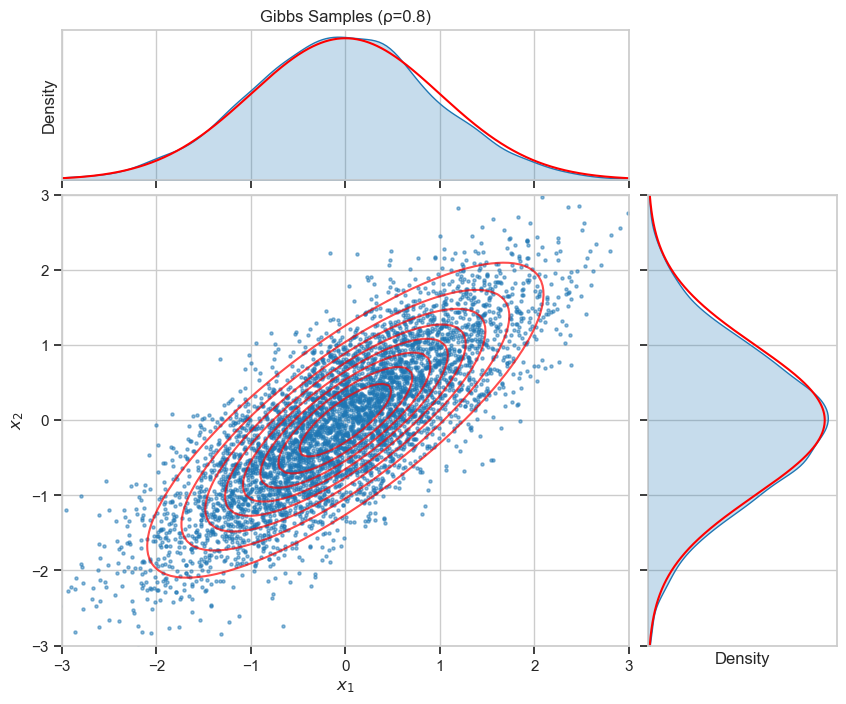

In [6]:
# Plot the samples
plot_2d_samples(samples, mean, cov, title=f"Gibbs Samples (ρ={rho})")

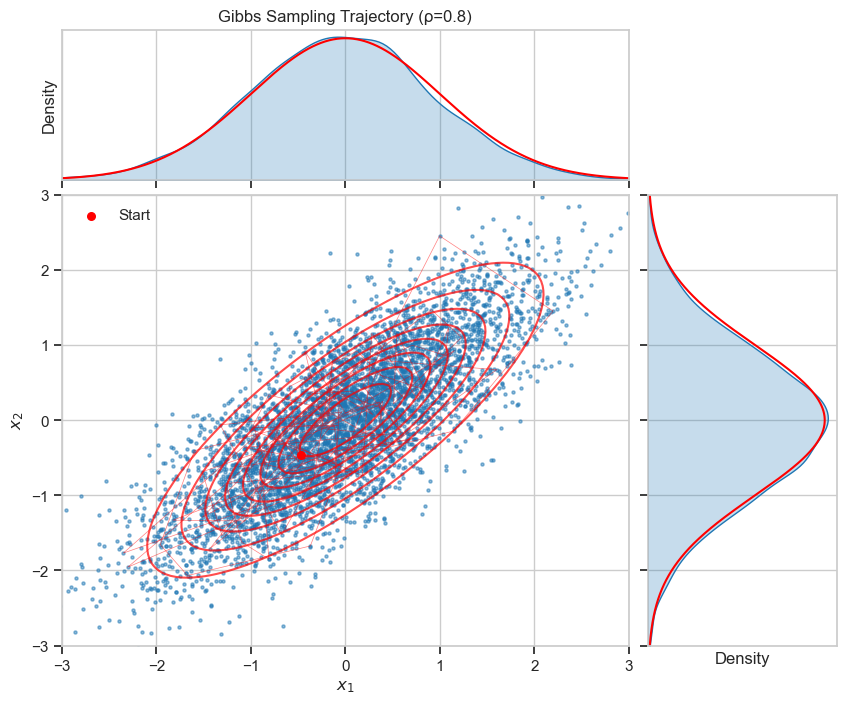

In [7]:
# Plot with trajectory to show the characteristic "right-angle" moves of Gibbs sampling
plot_2d_samples(samples, mean, cov, title=f"Gibbs Sampling Trajectory (ρ={rho})", show_trajectory=True, n_trajectory=100)

Let's also look at the trace plots and autocorrelation to assess mixing and convergence.

In [8]:
def plot_diagnostics(samples, parameter_names=None):
    """
    Plot trace plots and autocorrelation for MCMC samples.
    
    Parameters:
    -----------
    samples : array-like
        MCMC samples
    parameter_names : list, optional
        Names of the parameters
    """
    n_samples, dim = samples.shape
    
    if parameter_names is None:
        parameter_names = [f"$x_{i+1}$" for i in range(dim)]
    
    # Create figure
    fig, axes = plt.subplots(dim, 2, figsize=(12, 3*dim))
    
    # Plot trace and autocorrelation for each parameter
    for i in range(dim):
        # Trace plot
        axes[i, 0].plot(samples[:, i])
        axes[i, 0].set_title(f"Trace plot for {parameter_names[i]}")
        axes[i, 0].set_xlabel("Iteration")
        axes[i, 0].set_ylabel(parameter_names[i])
        
        # Autocorrelation plot
        lags = min(50, n_samples // 5)
        acf = np.zeros(lags)
        for lag in range(lags):
            acf[lag] = np.corrcoef(samples[lag:, i], samples[:-lag if lag > 0 else None, i])[0, 1]
        
        axes[i, 1].bar(range(lags), acf)
        axes[i, 1].set_title(f"Autocorrelation for {parameter_names[i]}")
        axes[i, 1].set_xlabel("Lag")
        axes[i, 1].set_ylabel("Autocorrelation")
    
    plt.tight_layout()
    plt.show()

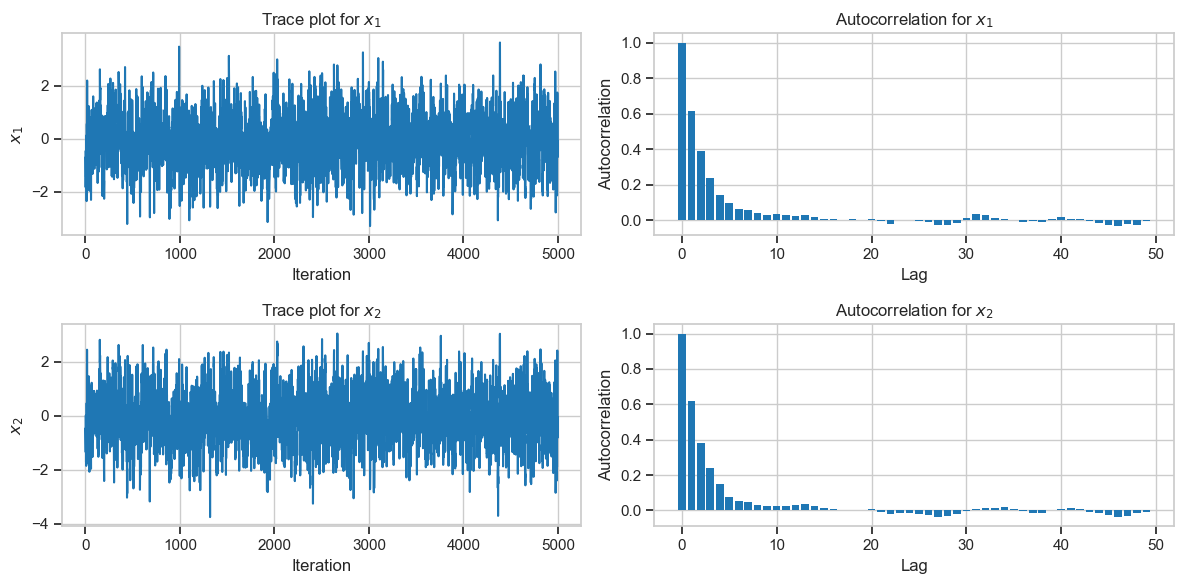

In [9]:
# Plot diagnostics
plot_diagnostics(samples)

### 3.1 Effect of Correlation

The correlation in the target distribution significantly affects the efficiency of Gibbs sampling. Let's experiment with different correlation values to see how they impact the mixing of the chain.

In [11]:
# Function to calculate effective sample size (ESS)
def calculate_ess(chain):
    """
    Calculate effective sample size using autocorrelation.
    
    Parameters:
    -----------
    chain : array-like
        MCMC chain
        
    Returns:
    --------
    ess : float
        Effective sample size
    """
    n = len(chain)
    lags = min(50, n // 5)
    acf = np.zeros(lags)
    for lag in range(lags):
        acf[lag] = np.corrcoef(chain[lag:], chain[:-lag if lag > 0 else None])[0, 1]
    # Truncate at first negative autocorrelation
    neg_idx = np.where(acf < 0)[0]
    if len(neg_idx) > 0:
        acf = acf[:neg_idx[0]]
    # Calculate ESS
    ess = n / (1 + 2 * np.sum(acf[1:]))
    return ess

Sampling:   0%|          | 0/2500 [00:00<?, ?it/s]

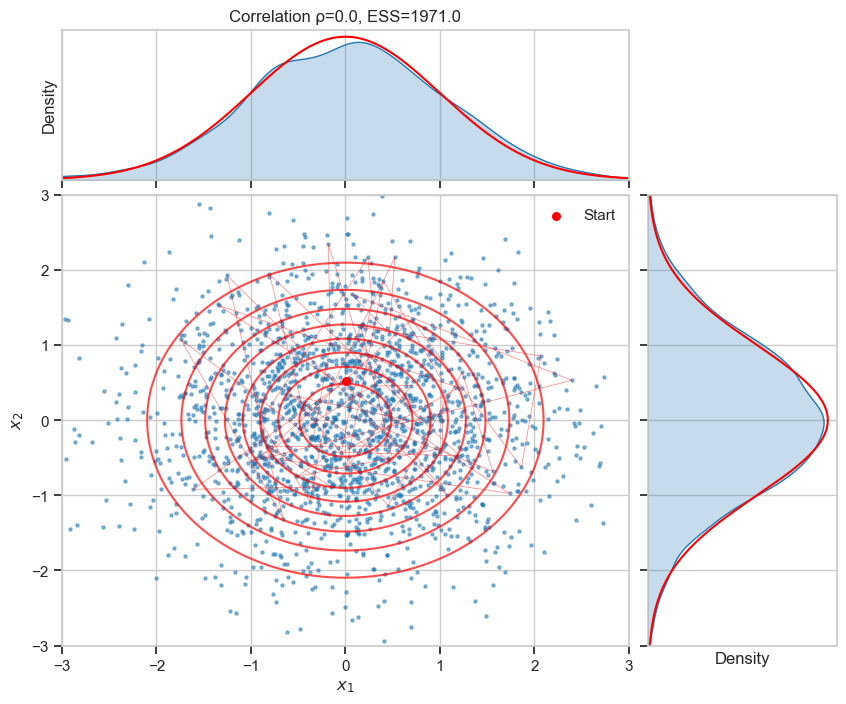

Sampling:   0%|          | 0/2500 [00:00<?, ?it/s]

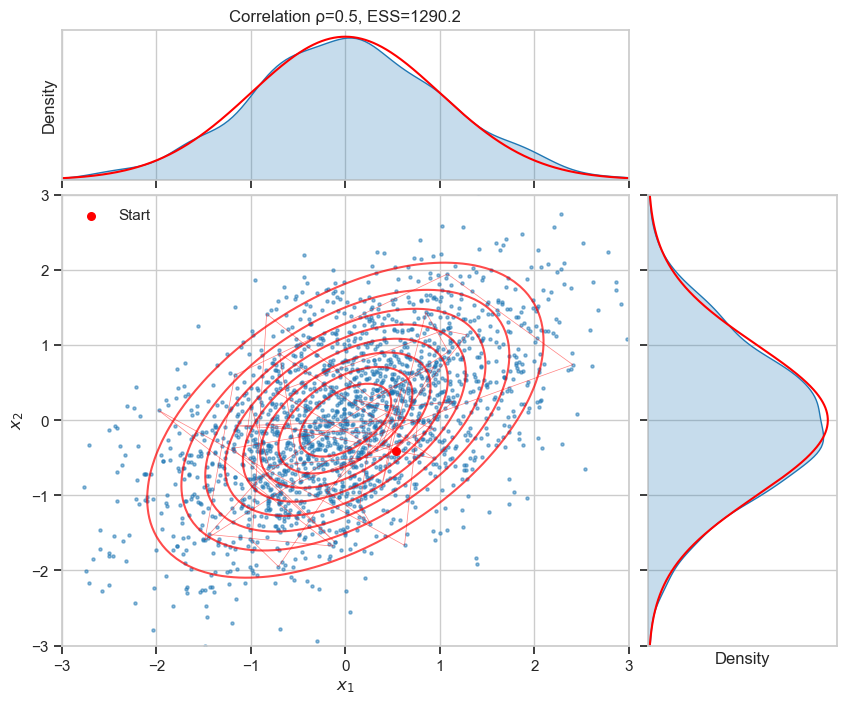

Sampling:   0%|          | 0/2500 [00:00<?, ?it/s]

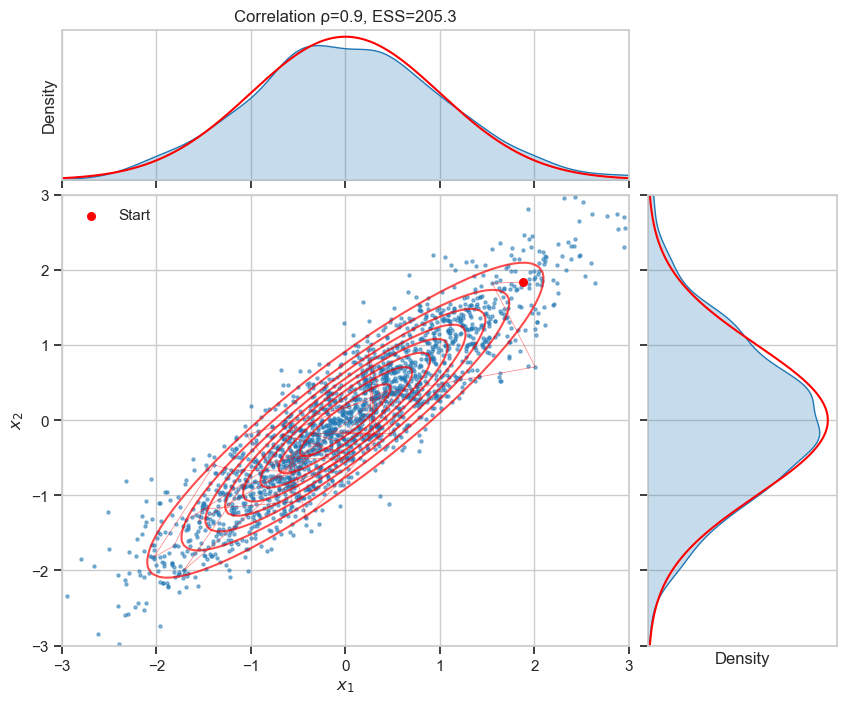

Sampling:   0%|          | 0/2500 [00:00<?, ?it/s]

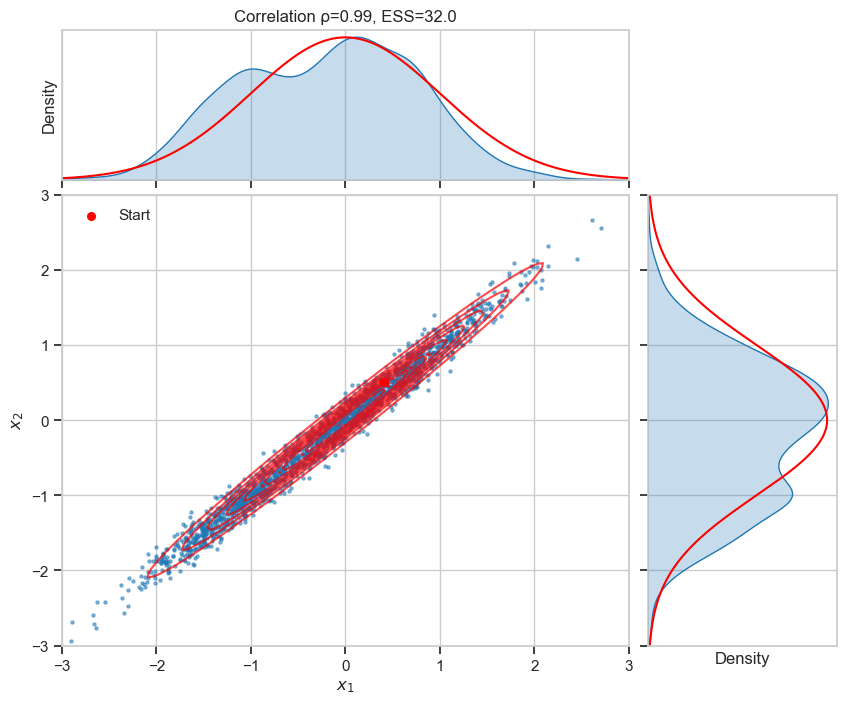

In [12]:
# Try different correlation values
rho_values = [0.0, 0.5, 0.9, 0.99]
corr_results = []

for rho in rho_values:
    # Update covariance matrix
    cov = np.array([[1, rho], [rho, 1]])
    
    # Create conditional samplers
    conditional_samplers = create_bivariate_normal_conditional_samplers(mean, cov)
    
    # Run sampler
    samples = gibbs_sampler(conditional_samplers, initial_state, n_samples=2000, burn_in=500, thin=1)
    
    # Calculate effective sample size
    ess_x1 = calculate_ess(samples[:, 0])
    ess_x2 = calculate_ess(samples[:, 1])
    ess_avg = (ess_x1 + ess_x2) / 2
    
    corr_results.append({
        'rho': rho,
        'ess_x1': ess_x1,
        'ess_x2': ess_x2,
        'ess_avg': ess_avg,
        'efficiency': ess_avg / 2000  # ESS per iteration
    })
    
    # Plot samples
    plot_2d_samples(samples, mean, cov, 
                   title=f"Correlation ρ={rho}, ESS={ess_avg:.1f}", 
                   show_trajectory=True, n_trajectory=50)

In [13]:
# Summarize correlation results
corr_results_df = pd.DataFrame(corr_results)
corr_results_df

,rho,ess_x1,ess_x2,ess_avg,efficiency
0,0.00,1941.950262,2000.000000,1970.975131,0.985488
1,0.50,1333.857761,1246.556325,1290.207043,0.645104
2,0.90,206.537143,204.077367,205.307255,0.102654
3,0.99,32.029210,31.971679,32.000444,0.016000


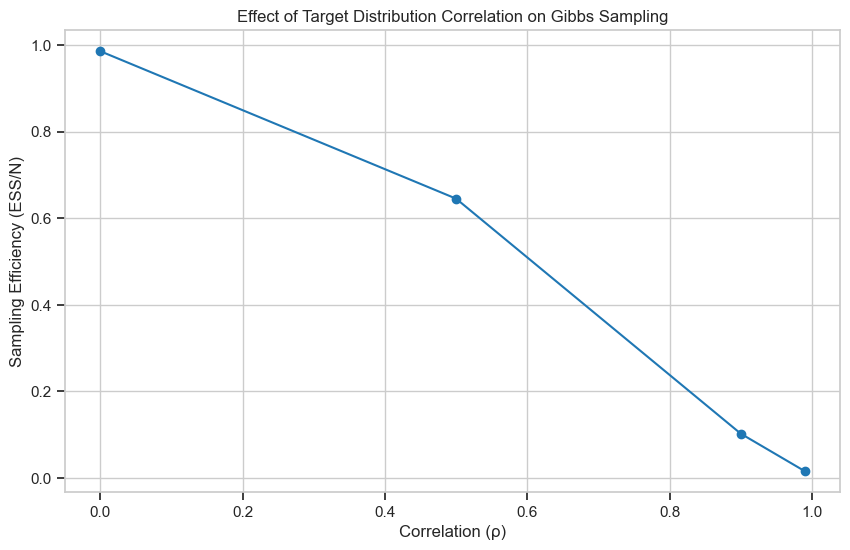

In [14]:
# Plot efficiency vs correlation
plt.figure(figsize=(10, 6))
plt.plot(corr_results_df['rho'], corr_results_df['efficiency'], 'o-')
plt.xlabel('Correlation (ρ)')
plt.ylabel('Sampling Efficiency (ESS/N)')
plt.title('Effect of Target Distribution Correlation on Gibbs Sampling')
plt.grid(True)
plt.show()

### 3.2 Comparison with Metropolis Algorithm

Let's compare the performance of Gibbs sampling with the Metropolis algorithm for the same bivariate normal distribution. We'll implement a simple Metropolis sampler for this comparison.

In [15]:
def metropolis_sampler(log_prob_func, initial_state, n_samples, proposal_std, burn_in=0, thin=1):
    """
    Metropolis algorithm for sampling from a probability distribution.
    
    Parameters:
    -----------
    log_prob_func : function
        Function that computes the log probability of a state
    initial_state : array-like
        Initial state of the Markov chain
    n_samples : int
        Number of samples to generate
    proposal_std : float or array-like
        Standard deviation of the Gaussian proposal distribution
    burn_in : int, optional
        Number of initial samples to discard
    thin : int, optional
        Thinning factor (keep every thin-th sample)
        
    Returns:
    --------
    samples : array
        Generated samples
    acceptance_rate : float
        Fraction of proposals that were accepted
    """
    # Convert initial state to numpy array if it isn't already
    current_state = np.array(initial_state, dtype=float)
    dim = current_state.shape[0]  # Dimensionality of the state
    
    # Total number of iterations needed
    n_iterations = burn_in + thin * n_samples
    
    # Initialize storage for samples and acceptance tracking
    samples = np.zeros((n_samples, dim))
    current_log_prob = log_prob_func(current_state)
    n_accepted = 0
    
    # Main sampling loop
    sample_idx = 0
    for i in tqdm(range(n_iterations), desc="Sampling"):
        # Propose a new state
        proposal = current_state + np.random.normal(0, proposal_std, size=dim)
        
        # Compute log probability of the proposed state
        proposal_log_prob = log_prob_func(proposal)
        
        # Compute log acceptance ratio
        log_acceptance_ratio = proposal_log_prob - current_log_prob
        
        # Accept or reject the proposal
        if np.log(np.random.random()) < log_acceptance_ratio:
            current_state = proposal
            current_log_prob = proposal_log_prob
            n_accepted += 1
        
        # Store the sample if past burn-in and due for storage based on thinning
        if i >= burn_in and (i - burn_in) % thin == 0:
            samples[sample_idx] = current_state
            sample_idx += 1
    
    # Compute acceptance rate
    acceptance_rate = n_accepted / n_iterations
    
    return samples, acceptance_rate

In [16]:
def multivariate_normal_log_pdf(x, mean, cov):
    """
    Compute the log PDF of a multivariate normal distribution.
    
    Parameters:
    -----------
    x : array-like
        Point at which to evaluate the PDF
    mean : array-like
        Mean vector of the distribution
    cov : array-like
        Covariance matrix of the distribution
        
    Returns:
    --------
    log_pdf : float
        Log probability density at x
    """
    x = np.array(x)
    mean = np.array(mean)
    cov = np.array(cov)
    dim = len(x)
    
    # Compute log determinant of covariance matrix
    sign, logdet = np.linalg.slogdet(cov)
    
    # Compute Mahalanobis distance
    diff = x - mean
    mahalanobis = diff.T @ np.linalg.inv(cov) @ diff
    
    # Compute log PDF
    log_pdf = -0.5 * (dim * np.log(2 * np.pi) + logdet + mahalanobis)
    
    return log_pdf

Sampling:   0%|          | 0/2500 [00:00<?, ?it/s]

Sampling:   0%|          | 0/2500 [00:00<?, ?it/s]

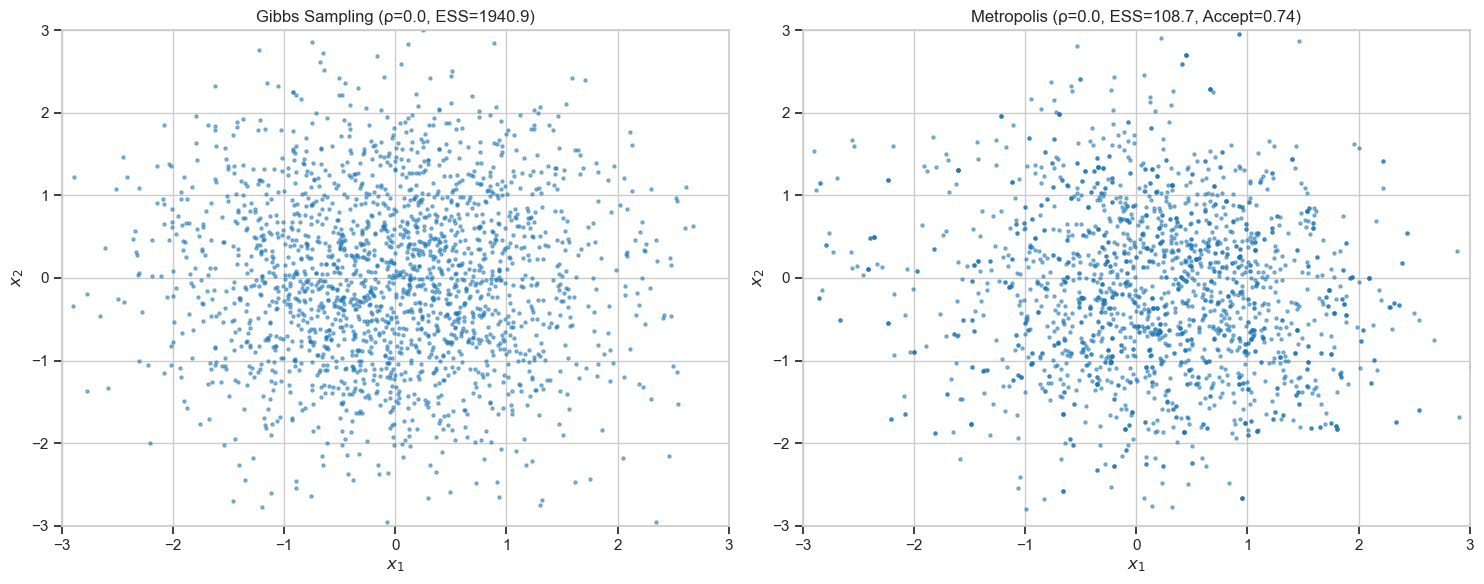

Sampling:   0%|          | 0/2500 [00:00<?, ?it/s]

Sampling:   0%|          | 0/2500 [00:00<?, ?it/s]

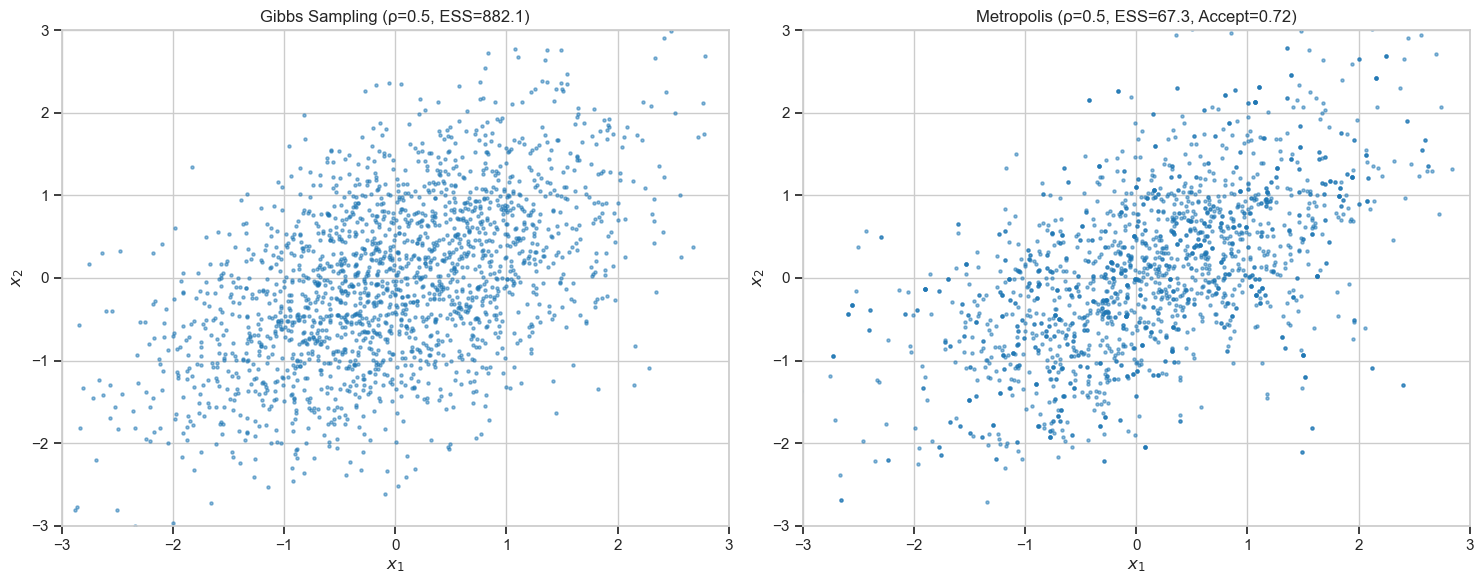

Sampling:   0%|          | 0/2500 [00:00<?, ?it/s]

Sampling:   0%|          | 0/2500 [00:00<?, ?it/s]

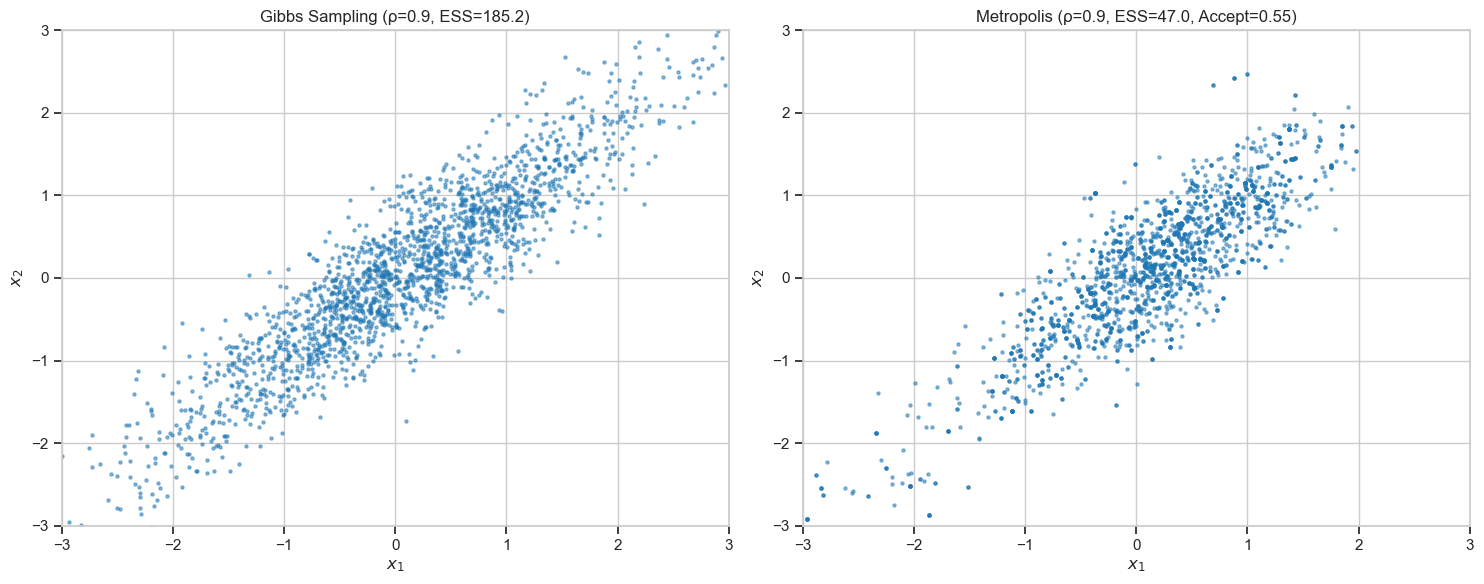

Sampling:   0%|          | 0/2500 [00:00<?, ?it/s]

Sampling:   0%|          | 0/2500 [00:00<?, ?it/s]

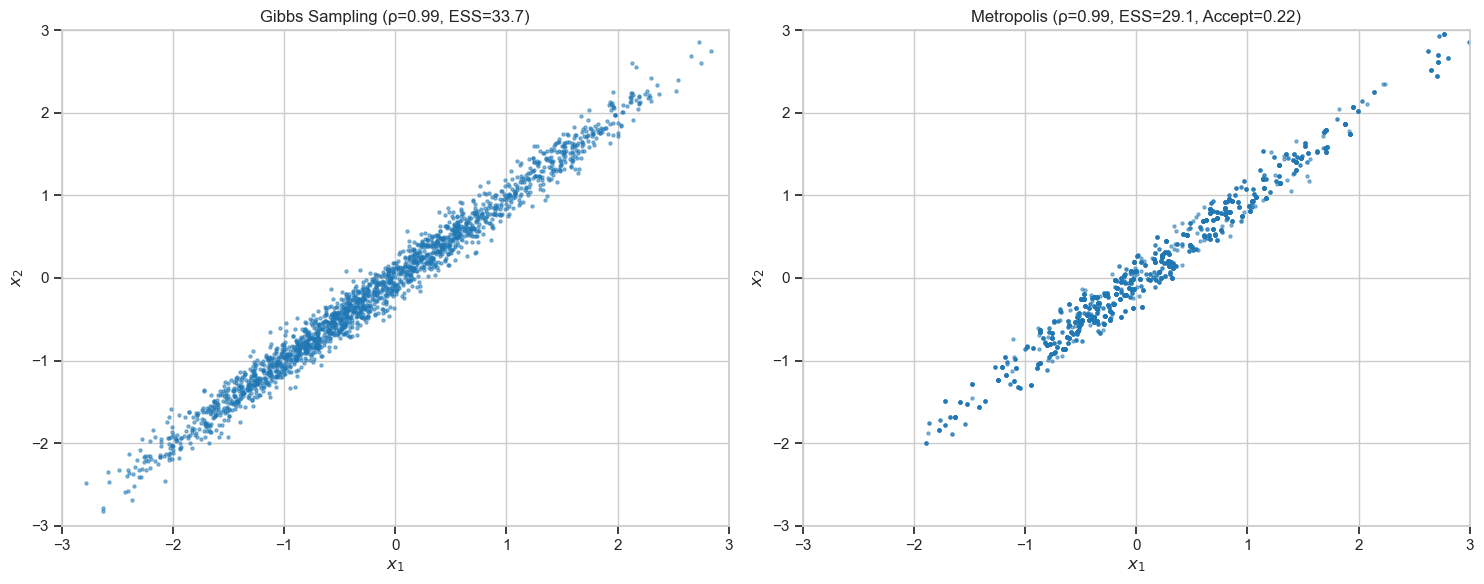

In [17]:
# Compare Gibbs and Metropolis for different correlation values
rho_values = [0.0, 0.5, 0.9, 0.99]
comparison_results = []

for rho in rho_values:
    # Update covariance matrix
    cov = np.array([[1, rho], [rho, 1]])
    
    # Create target log probability function for Metropolis
    def target_log_prob(x):
        return multivariate_normal_log_pdf(x, mean, cov)
    
    # Create conditional samplers for Gibbs
    conditional_samplers = create_bivariate_normal_conditional_samplers(mean, cov)
    
    # Run Gibbs sampler
    gibbs_samples = gibbs_sampler(conditional_samplers, initial_state, n_samples=2000, burn_in=500, thin=1)
    
    # Run Metropolis sampler
    metropolis_samples, acceptance_rate = metropolis_sampler(
        target_log_prob, initial_state, n_samples=2000, proposal_std=0.5, burn_in=500, thin=1
    )
    
    # Calculate effective sample size for Gibbs
    gibbs_ess_x1 = calculate_ess(gibbs_samples[:, 0])
    gibbs_ess_x2 = calculate_ess(gibbs_samples[:, 1])
    gibbs_ess_avg = (gibbs_ess_x1 + gibbs_ess_x2) / 2
    
    # Calculate effective sample size for Metropolis
    metropolis_ess_x1 = calculate_ess(metropolis_samples[:, 0])
    metropolis_ess_x2 = calculate_ess(metropolis_samples[:, 1])
    metropolis_ess_avg = (metropolis_ess_x1 + metropolis_ess_x2) / 2
    
    comparison_results.append({
        'rho': rho,
        'gibbs_ess_avg': gibbs_ess_avg,
        'gibbs_efficiency': gibbs_ess_avg / 2000,
        'metropolis_ess_avg': metropolis_ess_avg,
        'metropolis_efficiency': metropolis_ess_avg / 2000,
        'metropolis_acceptance_rate': acceptance_rate
    })
    
    # Plot comparison
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot Gibbs samples
    axes[0].scatter(gibbs_samples[:, 0], gibbs_samples[:, 1], alpha=0.5, s=5)
    axes[0].set_title(f"Gibbs Sampling (ρ={rho}, ESS={gibbs_ess_avg:.1f})")
    axes[0].set_xlabel('$x_1$')
    axes[0].set_ylabel('$x_2$')
    axes[0].set_xlim(-3, 3)
    axes[0].set_ylim(-3, 3)
    
    # Plot Metropolis samples
    axes[1].scatter(metropolis_samples[:, 0], metropolis_samples[:, 1], alpha=0.5, s=5)
    axes[1].set_title(f"Metropolis (ρ={rho}, ESS={metropolis_ess_avg:.1f}, Accept={acceptance_rate:.2f})")
    axes[1].set_xlabel('$x_1$')
    axes[1].set_ylabel('$x_2$')
    axes[1].set_xlim(-3, 3)
    axes[1].set_ylim(-3, 3)
    
    plt.tight_layout()
    plt.show()

In [18]:
# Summarize comparison results
comparison_df = pd.DataFrame(comparison_results)
comparison_df

,rho,gibbs_ess_avg,gibbs_efficiency,metropolis_ess_avg,metropolis_efficiency,metropolis_acceptance_rate
0,0.00,1940.923669,0.970462,108.749473,0.054375,0.7444
1,0.50,882.108493,0.441054,67.310877,0.033655,0.7244
2,0.90,185.150378,0.092575,47.015357,0.023508,0.5520
3,0.99,33.708784,0.016854,29.149160,0.014575,0.2236


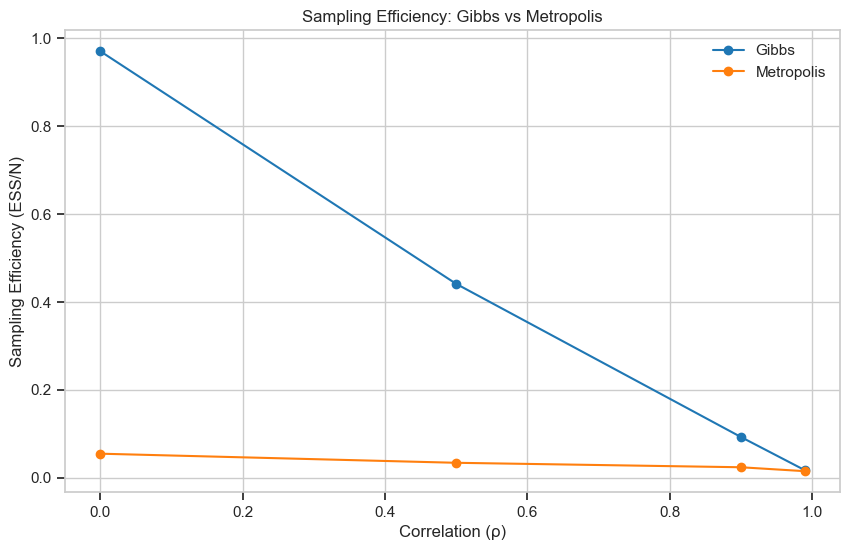

In [19]:
# Plot efficiency comparison
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['rho'], comparison_df['gibbs_efficiency'], 'o-', label='Gibbs')
plt.plot(comparison_df['rho'], comparison_df['metropolis_efficiency'], 'o-', label='Metropolis')
plt.xlabel('Correlation (ρ)')
plt.ylabel('Sampling Efficiency (ESS/N)')
plt.title('Sampling Efficiency: Gibbs vs Metropolis')
plt.legend()
plt.grid(True)
plt.show()

## 4. Example 2: Bayesian Mixture Model

Now, let's apply Gibbs sampling to a more complex problem: a Bayesian mixture model. This is a classic application where Gibbs sampling is particularly effective due to the natural conditional structure of the model.

We'll implement a Gaussian mixture model with $K$ components. The model is:

$$p(x_i | z_i, \mu, \sigma^2) = \mathcal{N}(x_i | \mu_{z_i}, \sigma^2_{z_i})$$
$$p(z_i | \pi) = \text{Categorical}(z_i | \pi)$$
$$p(\mu_k) = \mathcal{N}(\mu_k | \mu_0, \sigma^2_0)$$
$$p(\sigma^2_k) = \text{InverseGamma}(\sigma^2_k | \alpha, \beta)$$
$$p(\pi) = \text{Dirichlet}(\pi | \alpha_1, \ldots, \alpha_K)$$

where:
- $x_i$ are the observed data points
- $z_i$ are the latent component assignments
- $\mu_k$ are the component means
- $\sigma^2_k$ are the component variances
- $\pi$ are the component weights

### 4.1 Generate Synthetic Data

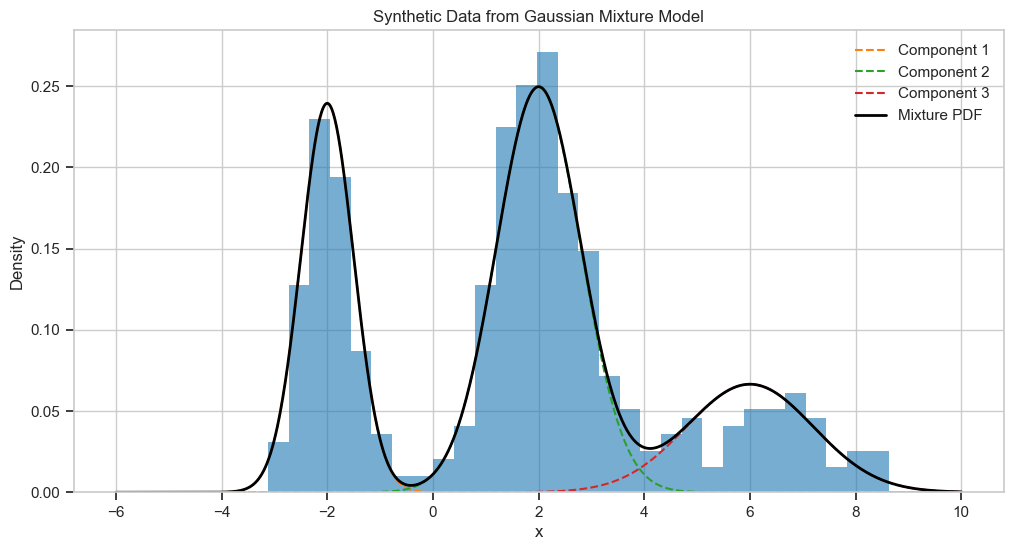

In [24]:
# Set true parameter values
true_means = np.array([-2.0, 2.0, 6.0])  # Component means
true_stds = np.array([0.5, 0.8, 1.2])    # Component standard deviations
true_weights = np.array([0.3, 0.5, 0.2])  # Component weights
n_components = len(true_means)

# Generate synthetic data
n_data = 500
true_components = np.random.choice(n_components, size=n_data, p=true_weights)
data = np.zeros(n_data)

for i in range(n_data):
    component = true_components[i]
    data[i] = np.random.normal(true_means[component], true_stds[component])

# Plot the data
plt.figure(figsize=(12, 6))
plt.hist(data, bins=30, density=True, alpha=0.6)

# Plot the true mixture components
x = np.linspace(-6, 10, 1000)
mixture_pdf = np.zeros_like(x)

for i in range(n_components):
    component_pdf = true_weights[i] * stats.norm.pdf(x, true_means[i], true_stds[i])
    mixture_pdf += component_pdf
    plt.plot(x, component_pdf, '--', label=f'Component {i+1}')

plt.plot(x, mixture_pdf, 'k-', linewidth=2, label='Mixture PDF')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Synthetic Data from Gaussian Mixture Model')
plt.legend()
plt.grid(True)
plt.show()

### 4.2 Implement Gibbs Sampler for Mixture Model

Now, let's implement the Gibbs sampler for the mixture model. We need to derive the conditional distributions for each parameter:

1. Component assignments $z_i | x_i, \mu, \sigma^2, \pi$
2. Component means $\mu_k | x, z, \sigma^2, \pi$
3. Component variances $\sigma^2_k | x, z, \mu, \pi$
4. Component weights $\pi | x, z, \mu, \sigma^2$

In [30]:
def gibbs_sampler_mixture_model(data, n_components, n_samples, burn_in=0, thin=1):
    """
    Gibbs sampler for a Gaussian mixture model.
    
    Parameters:
    -----------
    data : array-like
        Observed data
    n_components : int
        Number of mixture components
    n_samples : int
        Number of samples to generate
    burn_in : int, optional
        Number of initial samples to discard
    thin : int, optional
        Thinning factor (keep every thin-th sample)
        
    Returns:
    --------
    samples : dict
        Dictionary containing samples for each parameter
    """
    n_data = len(data)
    
    # Total number of iterations needed
    n_iterations = burn_in + thin * n_samples
    
    # Initialize storage for samples
    samples = {
        'means': np.zeros((n_samples, n_components)),
        'stds': np.zeros((n_samples, n_components)),
        'weights': np.zeros((n_samples, n_components)),
        'components': np.zeros((n_samples, n_data), dtype=int)
    }
    
    # Initialize parameters
    # Use K-means to get initial values
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=n_components, random_state=42).fit(data.reshape(-1, 1))
    
    current_means = kmeans.cluster_centers_.flatten()
    current_stds = np.ones(n_components)
    current_weights = np.ones(n_components) / n_components
    current_components = kmeans.labels_
    
    # Set hyperparameters for priors
    # Mean prior: N(mu_0, sigma_0^2)
    mu_0 = np.mean(data)
    sigma_0 = np.std(data)
    
    # Variance prior: InverseGamma(alpha, beta)
    alpha = 2.0
    beta = 1.0
    
    # Weight prior: Dirichlet(alpha_1, ..., alpha_K)
    alpha_weights = np.ones(n_components)
    
    # Main sampling loop
    sample_idx = 0
    for i in tqdm(range(n_iterations), desc="Sampling"):
        # 1. Sample component assignments
        for j in range(n_data):
            # Compute log probabilities for each component
            log_probs = np.log(current_weights) + \
                        stats.norm.logpdf(data[j], current_means, current_stds)
            
            # Normalize to get probabilities
            log_probs -= np.max(log_probs)  # For numerical stability
            probs = np.exp(log_probs)
            probs /= np.sum(probs)
            
            # Sample new component
            current_components[j] = np.random.choice(n_components, p=probs)
        
        # 2. Sample component means
        for k in range(n_components):
            # Get data points assigned to this component
            mask = (current_components == k)
            n_k = np.sum(mask)
            
            if n_k > 0:
                # Compute posterior parameters
                x_bar = np.mean(data[mask]) if n_k > 0 else 0
                sigma_k = current_stds[k]
                
                # Posterior precision (1/variance)
                precision_0 = 1.0 / (sigma_0 ** 2)
                precision_k = n_k / (sigma_k ** 2)
                precision_posterior = precision_0 + precision_k
                
                # Posterior mean
                mean_posterior = (precision_0 * mu_0 + precision_k * x_bar) / precision_posterior
                
                # Posterior standard deviation
                std_posterior = np.sqrt(1.0 / precision_posterior)
                
                # Sample new mean
                current_means[k] = np.random.normal(mean_posterior, std_posterior)
        
        # 3. Sample component variances
        for k in range(n_components):
            # Get data points assigned to this component
            mask = (current_components == k)
            n_k = np.sum(mask)
            
            if n_k > 0:
                # Compute sum of squared deviations
                sum_sq_dev = np.sum((data[mask] - current_means[k]) ** 2)
                
                # Posterior shape and scale parameters
                alpha_posterior = alpha + n_k / 2.0
                beta_posterior = beta + sum_sq_dev / 2.0
                
                # Sample new variance
                current_stds[k] = np.sqrt(1.0 / np.random.gamma(alpha_posterior, 1.0 / beta_posterior))
        
        # 4. Sample component weights
        # Count number of data points in each component
        component_counts = np.zeros(n_components)
        for k in range(n_components):
            component_counts[k] = np.sum(current_components == k)
        
        # Sample from Dirichlet distribution
        alpha_posterior = alpha_weights + component_counts
        current_weights = np.random.dirichlet(alpha_posterior)
        
        # Store the sample if past burn-in and due for storage based on thinning
        if i >= burn_in and (i - burn_in) % thin == 0:
            samples['means'][sample_idx] = current_means
            samples['stds'][sample_idx] = current_stds
            samples['weights'][sample_idx] = current_weights
            samples['components'][sample_idx] = current_components
            sample_idx += 1
    
    return samples

In [31]:
# Run the Gibbs sampler for the mixture model
n_samples = 2000
burn_in = 500
thin = 2

mixture_samples = gibbs_sampler_mixture_model(data, n_components, n_samples, burn_in, thin)

Sampling:   0%|          | 0/4500 [00:00<?, ?it/s]

### 4.3 Analyze the Results

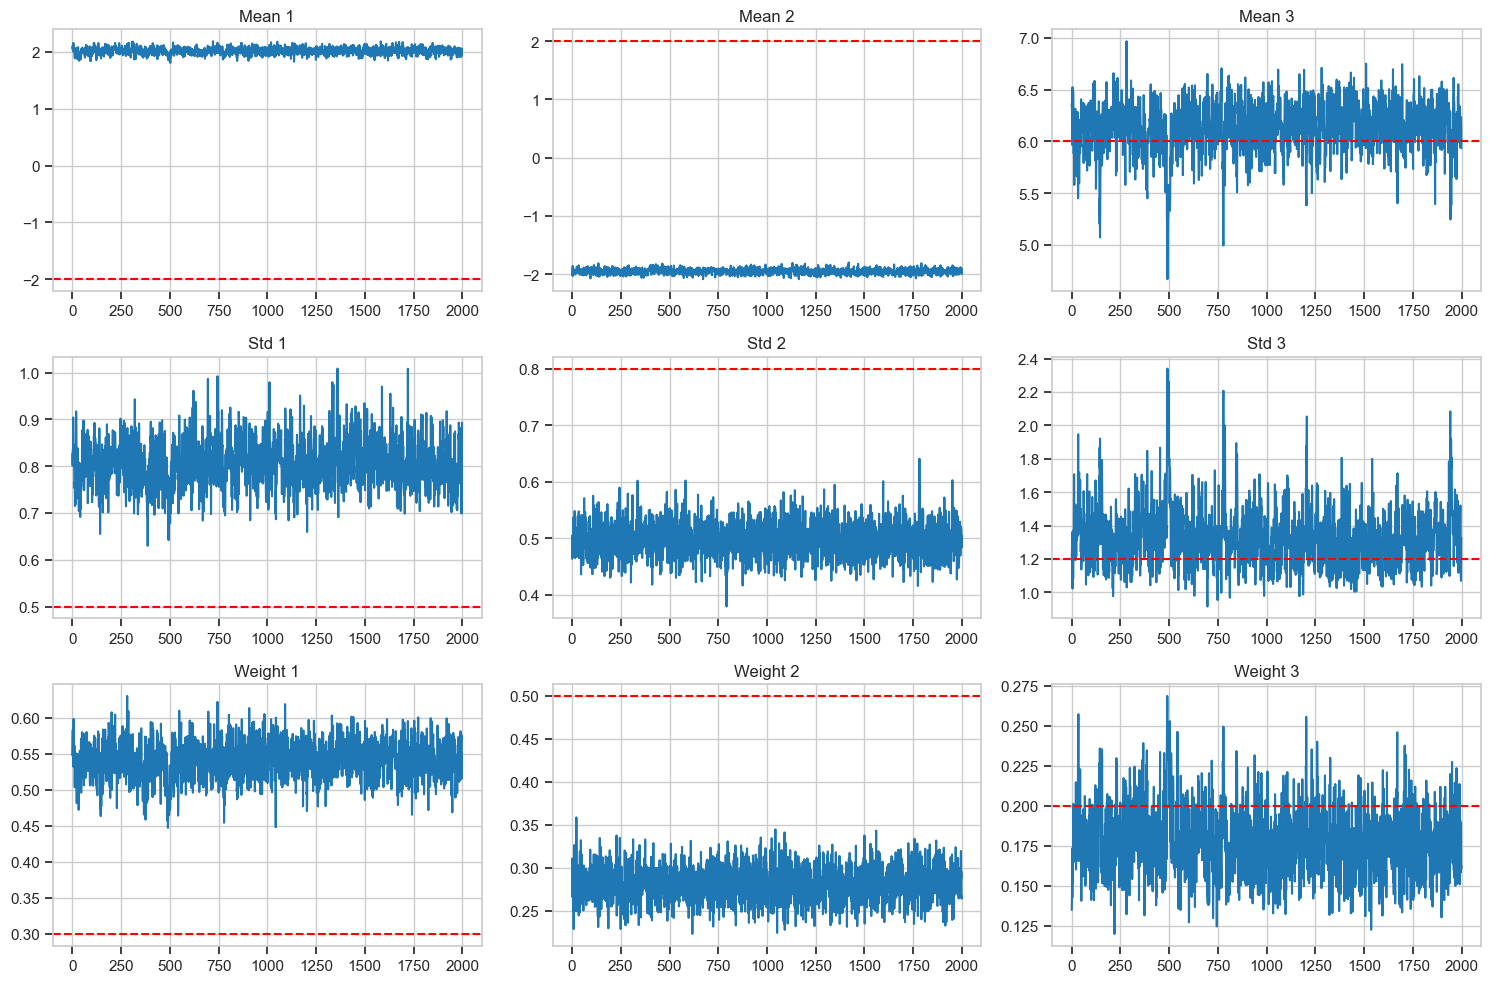

In [32]:
# Plot trace plots for means, stds, and weights
fig, axes = plt.subplots(3, n_components, figsize=(15, 10))

for k in range(n_components):
    # Means
    axes[0, k].plot(mixture_samples['means'][:, k])
    axes[0, k].axhline(true_means[k], color='r', linestyle='--')
    axes[0, k].set_title(f'Mean {k+1}')
    
    # Standard deviations
    axes[1, k].plot(mixture_samples['stds'][:, k])
    axes[1, k].axhline(true_stds[k], color='r', linestyle='--')
    axes[1, k].set_title(f'Std {k+1}')
    
    # Weights
    axes[2, k].plot(mixture_samples['weights'][:, k])
    axes[2, k].axhline(true_weights[k], color='r', linestyle='--')
    axes[2, k].set_title(f'Weight {k+1}')

plt.tight_layout()
plt.show()

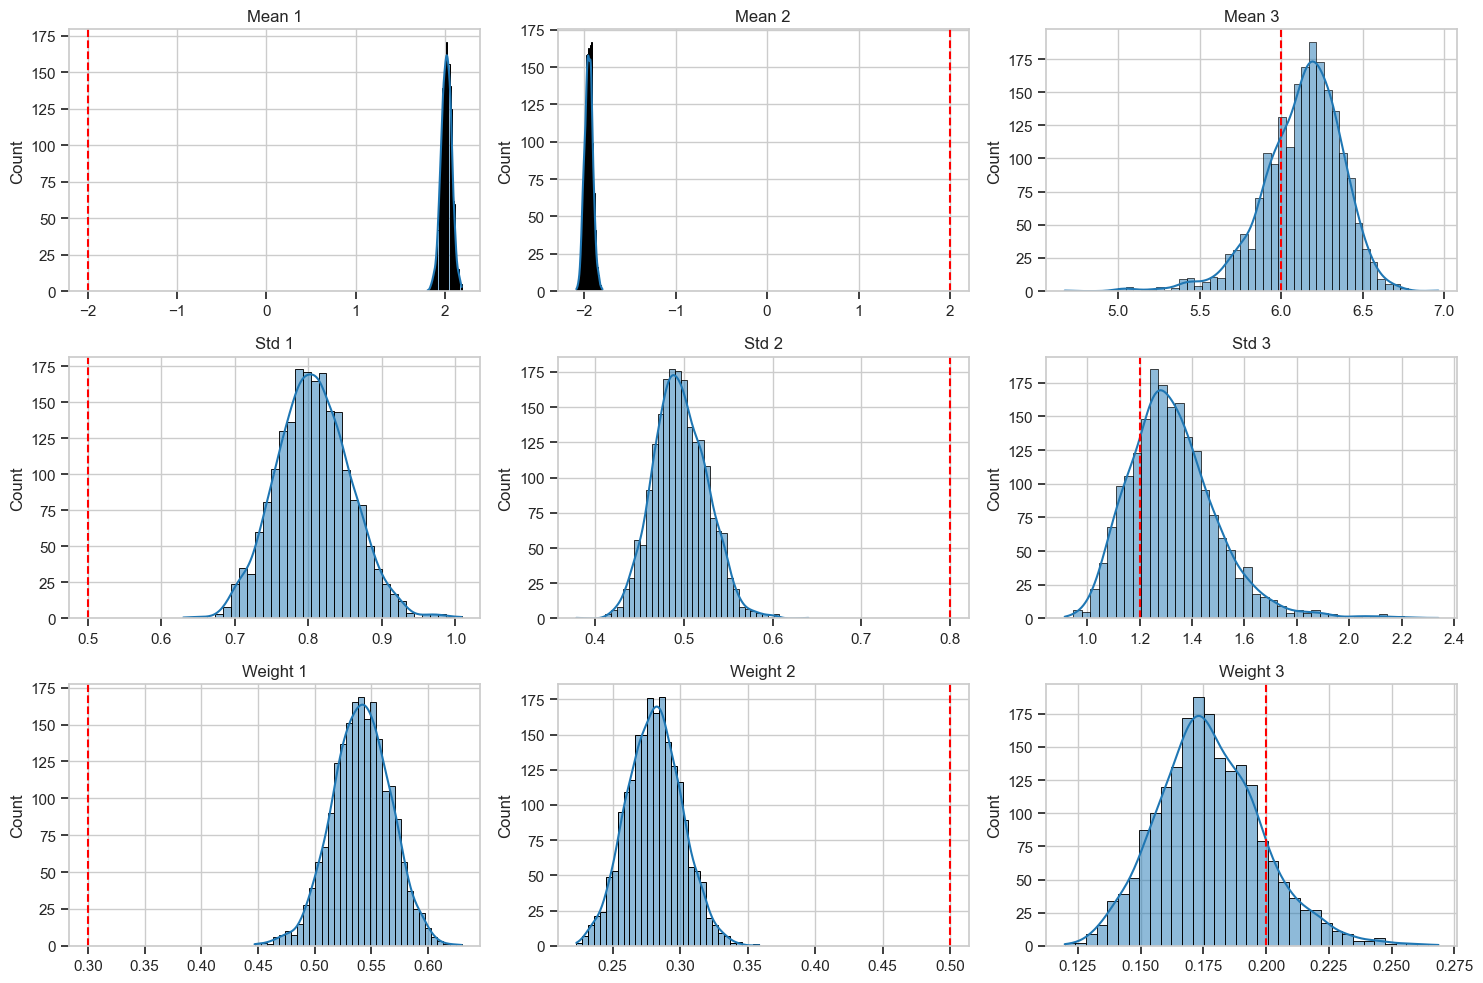

In [33]:
# Plot posterior distributions for means, stds, and weights
fig, axes = plt.subplots(3, n_components, figsize=(15, 10))

for k in range(n_components):
    # Means
    sns.histplot(mixture_samples['means'][:, k], kde=True, ax=axes[0, k])
    axes[0, k].axvline(true_means[k], color='r', linestyle='--')
    axes[0, k].set_title(f'Mean {k+1}')
    
    # Standard deviations
    sns.histplot(mixture_samples['stds'][:, k], kde=True, ax=axes[1, k])
    axes[1, k].axvline(true_stds[k], color='r', linestyle='--')
    axes[1, k].set_title(f'Std {k+1}')
    
    # Weights
    sns.histplot(mixture_samples['weights'][:, k], kde=True, ax=axes[2, k])
    axes[2, k].axvline(true_weights[k], color='r', linestyle='--')
    axes[2, k].set_title(f'Weight {k+1}')

plt.tight_layout()
plt.show()

In [34]:
# Compute posterior means
posterior_means = np.mean(mixture_samples['means'], axis=0)
posterior_stds = np.mean(mixture_samples['stds'], axis=0)
posterior_weights = np.mean(mixture_samples['weights'], axis=0)

# Sort components by mean for easier comparison
sort_idx = np.argsort(posterior_means)
posterior_means = posterior_means[sort_idx]
posterior_stds = posterior_stds[sort_idx]
posterior_weights = posterior_weights[sort_idx]

# Sort true parameters in the same way
true_sort_idx = np.argsort(true_means)
true_means_sorted = true_means[true_sort_idx]
true_stds_sorted = true_stds[true_sort_idx]
true_weights_sorted = true_weights[true_sort_idx]

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Parameter': ['Mean 1', 'Mean 2', 'Mean 3', 'Std 1', 'Std 2', 'Std 3', 'Weight 1', 'Weight 2', 'Weight 3'],
    'True Value': np.concatenate([true_means_sorted, true_stds_sorted, true_weights_sorted]),
    'Posterior Mean': np.concatenate([posterior_means, posterior_stds, posterior_weights])
})

comparison_df

,Parameter,True Value,Posterior Mean
0,Mean 1,-2.0,-1.950302
1,Mean 2,2.0,2.016809
2,Mean 3,6.0,6.132214
3,Std 1,0.5,0.496078
4,Std 2,0.8,0.806804
5,Std 3,1.2,1.328271
6,Weight 1,0.3,0.280987
7,Weight 2,0.5,0.541222
8,Weight 3,0.2,0.177790


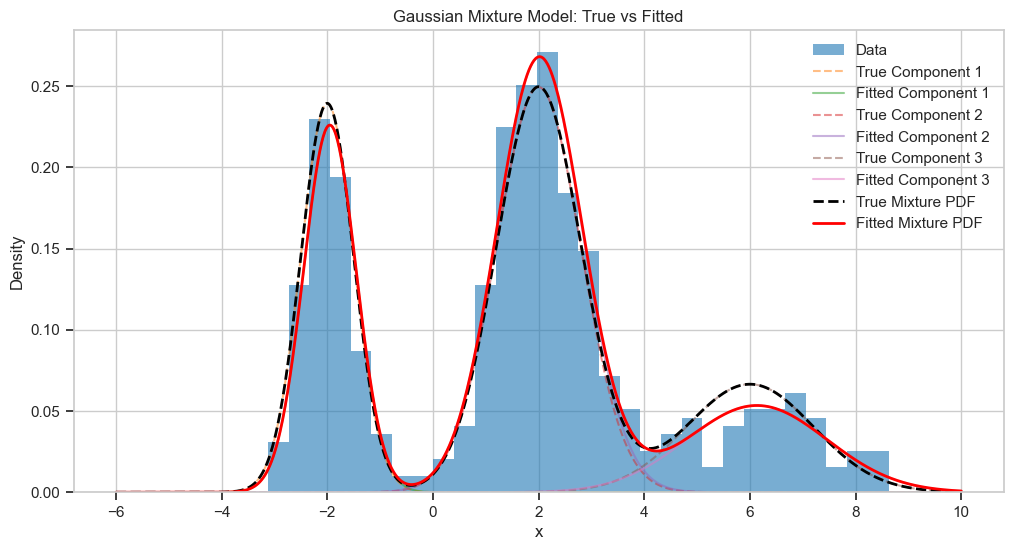

In [35]:
# Plot the data with the fitted mixture model
plt.figure(figsize=(12, 6))
plt.hist(data, bins=30, density=True, alpha=0.6, label='Data')

# Plot the true mixture components
x = np.linspace(-6, 10, 1000)
true_mixture_pdf = np.zeros_like(x)
fitted_mixture_pdf = np.zeros_like(x)

for i in range(n_components):
    # True components
    true_component_pdf = true_weights_sorted[i] * stats.norm.pdf(x, true_means_sorted[i], true_stds_sorted[i])
    true_mixture_pdf += true_component_pdf
    plt.plot(x, true_component_pdf, '--', alpha=0.5, label=f'True Component {i+1}')
    
    # Fitted components
    fitted_component_pdf = posterior_weights[i] * stats.norm.pdf(x, posterior_means[i], posterior_stds[i])
    fitted_mixture_pdf += fitted_component_pdf
    plt.plot(x, fitted_component_pdf, '-', alpha=0.5, label=f'Fitted Component {i+1}')

plt.plot(x, true_mixture_pdf, 'k--', linewidth=2, label='True Mixture PDF')
plt.plot(x, fitted_mixture_pdf, 'r-', linewidth=2, label='Fitted Mixture PDF')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Gaussian Mixture Model: True vs Fitted')
plt.legend()
plt.grid(True)
plt.show()

### 4.4 Label Switching

One challenge in Bayesian mixture models is the "label switching" problem, where the component labels can switch during sampling due to the symmetry of the model. Let's examine this issue.

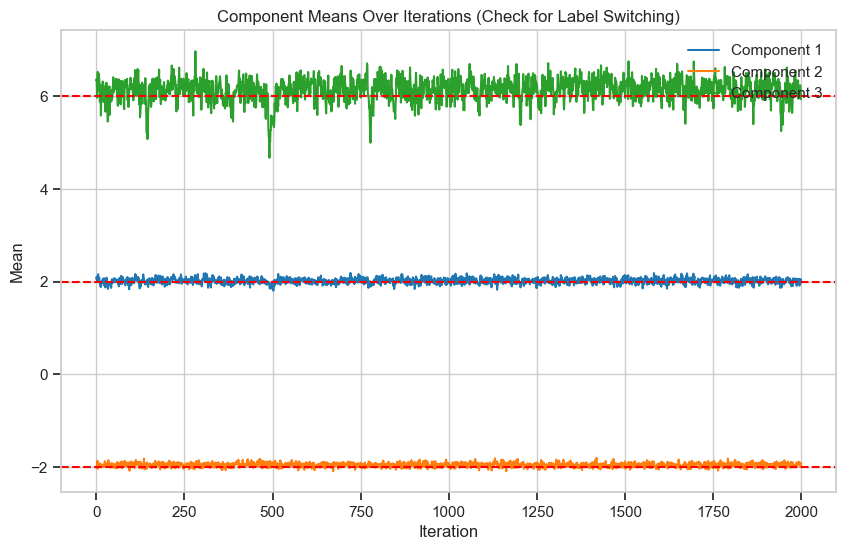

In [36]:
# Plot means over iterations to check for label switching
plt.figure(figsize=(10, 6))
for k in range(n_components):
    plt.plot(mixture_samples['means'][:, k], label=f'Component {k+1}')

for k in range(n_components):
    plt.axhline(true_means[k], color='r', linestyle='--')

plt.xlabel('Iteration')
plt.ylabel('Mean')
plt.title('Component Means Over Iterations (Check for Label Switching)')
plt.legend()
plt.grid(True)
plt.show()

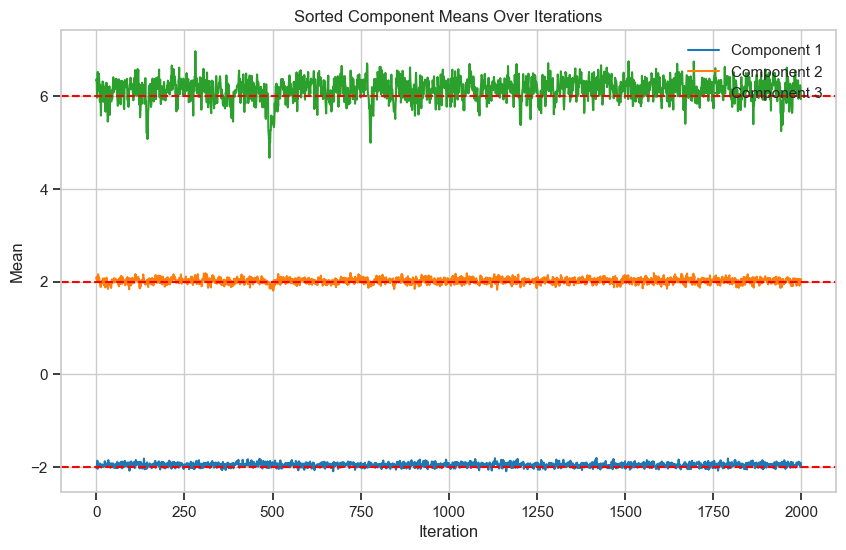

In [37]:
# One approach to handle label switching is to sort the components at each iteration
# Let's reprocess the samples with sorted components

# Initialize storage for sorted samples
sorted_samples = {
    'means': np.zeros_like(mixture_samples['means']),
    'stds': np.zeros_like(mixture_samples['stds']),
    'weights': np.zeros_like(mixture_samples['weights'])
}

# Sort components by mean at each iteration
for i in range(len(mixture_samples['means'])):
    sort_idx = np.argsort(mixture_samples['means'][i])
    sorted_samples['means'][i] = mixture_samples['means'][i, sort_idx]
    sorted_samples['stds'][i] = mixture_samples['stds'][i, sort_idx]
    sorted_samples['weights'][i] = mixture_samples['weights'][i, sort_idx]

# Plot sorted means
plt.figure(figsize=(10, 6))
for k in range(n_components):
    plt.plot(sorted_samples['means'][:, k], label=f'Component {k+1}')

# Sort true means for comparison
true_means_sorted = np.sort(true_means)
for k in range(n_components):
    plt.axhline(true_means_sorted[k], color='r', linestyle='--')

plt.xlabel('Iteration')
plt.ylabel('Mean')
plt.title('Sorted Component Means Over Iterations')
plt.legend()
plt.grid(True)
plt.show()

## 5. Limitations and Extensions of Gibbs Sampling

### 5.1 Limitations

Gibbs sampling, while powerful, has several limitations:

1. **Requires Conditional Distributions**: The algorithm requires that we can sample from the conditional distribution of each variable given all others, which may not always be possible or efficient.

2. **Poor Mixing with Strong Correlations**: When variables are highly correlated, the coordinate-wise updates of Gibbs sampling can lead to slow mixing and exploration of the parameter space.

3. **Difficulty with Complex Posteriors**: For complex posterior distributions with multiple modes or irregular shapes, Gibbs sampling may get stuck in one region.

4. **Label Switching in Mixture Models**: As we saw, mixture models suffer from the label switching problem, where component identities can change during sampling.

### 5.2 Extensions and Alternatives

Several extensions and alternatives address these limitations:

1. **Blocked Gibbs Sampling**: Updates groups of variables together, which can improve mixing when variables are correlated.

2. **Collapsed Gibbs Sampling**: Integrates out some variables analytically, reducing the dimensionality of the sampling space.

3. **Metropolis-within-Gibbs**: Uses Metropolis steps for variables whose conditionals are difficult to sample from directly.

4. **Hamiltonian Monte Carlo (HMC)**: Uses gradient information to propose more distant states, reducing random walk behavior and improving mixing in high dimensions.

5. **No-U-Turn Sampler (NUTS)**: An adaptive version of HMC that automatically tunes the number of leapfrog steps.

## 6. Conclusion

In this notebook, we've explored the Gibbs sampling algorithm, a powerful MCMC method for sampling from multivariate distributions. We've implemented it from scratch and applied it to sample from bivariate normal distributions and to fit a Bayesian mixture model.

Key takeaways:

1. Gibbs sampling is particularly effective when the conditional distributions are known and easy to sample from.

2. The algorithm updates one variable at a time, which can be inefficient when variables are highly correlated.

3. For problems with a natural conditional structure, such as hierarchical models and mixture models, Gibbs sampling can be very efficient.

4. The performance of Gibbs sampling depends on the correlation structure of the target distribution and the parameterization of the model.

5. Extensions like blocked Gibbs sampling and collapsed Gibbs sampling can improve efficiency for specific problems.

In the next notebook, we'll explore Hamiltonian Monte Carlo (HMC), which addresses some of the limitations of Gibbs sampling, particularly for high-dimensional problems with complex geometries.